In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [3]:
data = pd.read_csv("../data/processed/credit_processed.csv")

# Handle target column safely
target_col = "Class" if "Class" in data.columns else "class"

X = data.drop(columns=[target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    eval_metric="aucpr",
    random_state=42
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

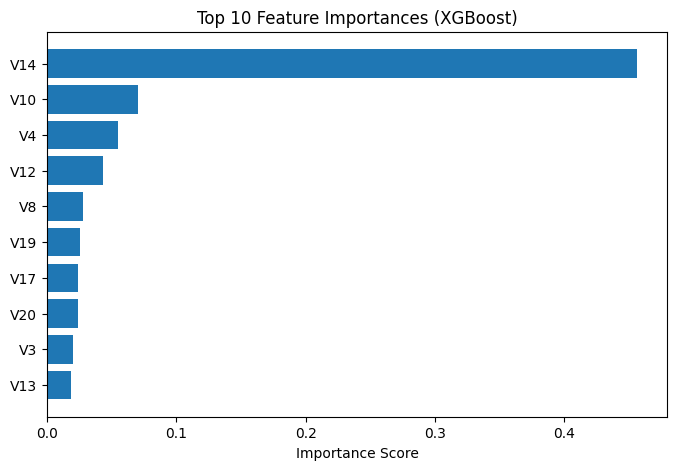

In [4]:
importances = model.feature_importances_

fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top10_fi = fi_df.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top10_fi["feature"], top10_fi["importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.show()


In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

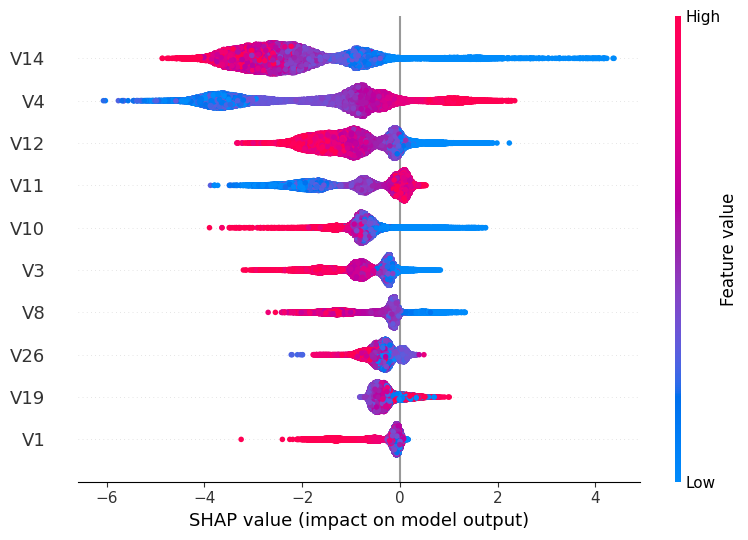

In [6]:
shap.summary_plot(
    shap_values,
    X_test,
    max_display=10,
    show=True
)


In [7]:
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred
results["y_prob"] = y_probs

# True Positive
tp_idx = results[(results.y_true == 1) & (results.y_pred == 1)].index[0]

# False Positive
fp_idx = results[(results.y_true == 0) & (results.y_pred == 1)].index[0]

# False Negative
fn_idx = results[(results.y_true == 1) & (results.y_pred == 0)].index[0]


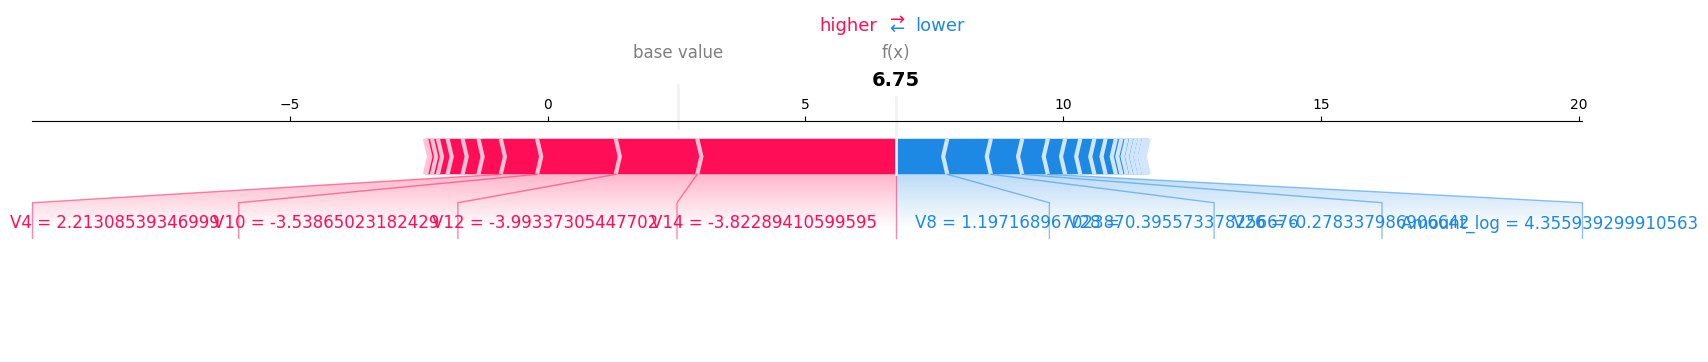

In [8]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_test.index.get_loc(tp_idx)],
    X_test.loc[tp_idx],
    matplotlib=True
)

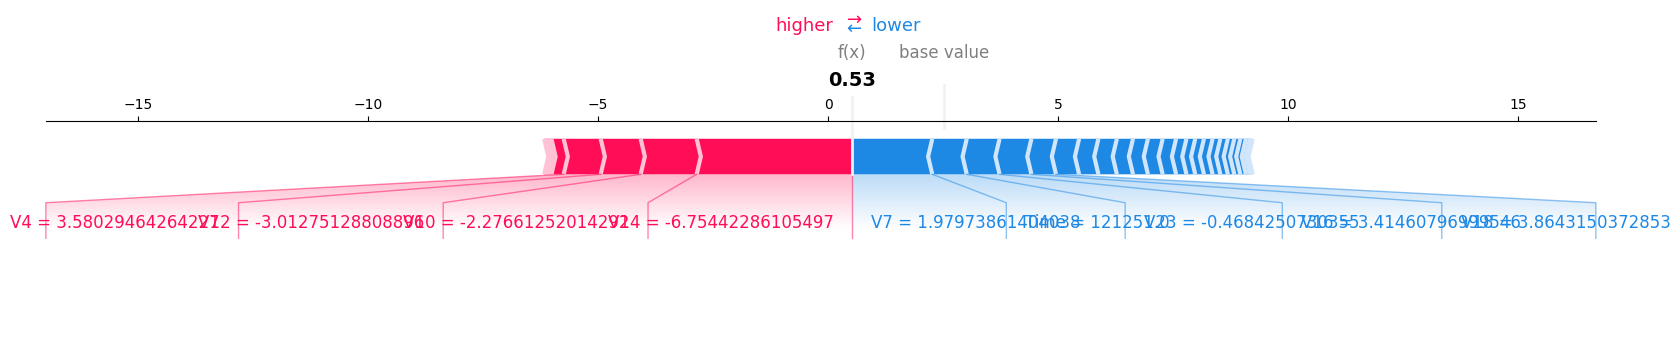

In [9]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_test.index.get_loc(fp_idx)],
    X_test.loc[fp_idx],
    matplotlib=True
)


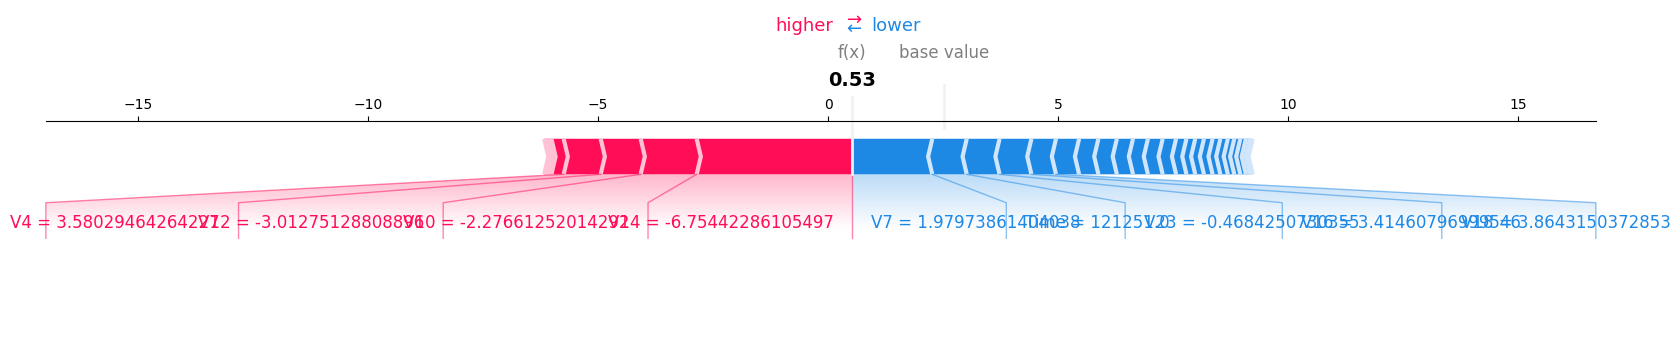

In [10]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_test.index.get_loc(fp_idx)],
    X_test.loc[fp_idx],
    matplotlib=True
)


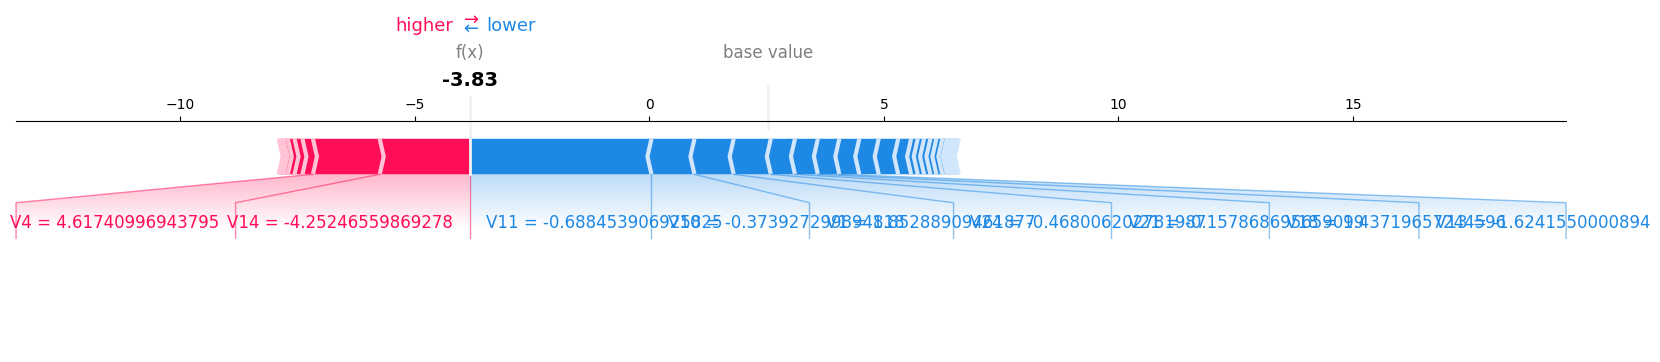

In [11]:
shap.force_plot(
    explainer.expected_value,
    shap_values[X_test.index.get_loc(fn_idx)],
    X_test.loc[fn_idx],
    matplotlib=True
)
